In [83]:
# Import libraries
from dateutil.parser import parse 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [84]:
# Retrieve database
ladnaus = 'https://raw.githubusercontent.com/SukheshNuthalapati/BeeSnap-ML/master/HiveTool/LadnhausHainsHiveTool%20-%20Sheet1.csv'

df = pd.read_csv(ladnaus)

# Clean database to only observe needed variables
# Our independent variable is date (we are conducting a time series analysis)
# Our dependent (endogenous) variable is hive_weight
# Our exogenous variables are hive_temperature, hive_humidity, ambient_temperature, ambient_humidity, ambient_rain
df = df.iloc[14:-100]
df = df[['date', 'hive_weight', 'hive_temperature', 'hive_humidity', 'ambient_temperature', 'ambient_humidity', 'ambient_rain']]
df

,date,hive_weight,hive_temperature,hive_humidity,ambient_temperature,ambient_humidity,ambient_rain
14,2013-09-30 0:00:00,82.984,72.1,0.0,32.0,0.0,65.7
15,2013-10-01 0:00:00,82.812,72.1,0.0,32.0,0.0,59.9
16,2013-10-02 0:00:00,82.527,72.1,0.0,32.0,0.0,58.6
17,2013-10-03 0:00:00,82.318,72.1,0.0,32.0,0.0,58.3
18,2013-10-04 0:00:00,81.981,72.1,0.0,32.0,0.0,59.4
...,...,...,...,...,...,...,...
1392,2017-07-17 0:00:00,116.383,74.4,NaN,78.2,NaN,72.9
1393,2017-07-18 0:00:00,116.997,68.2,NaN,72.0,NaN,64.6
1394,2017-07-19 0:00:00,117.688,67.5,NaN,71.0,NaN,65.1
1395,2017-07-20 0:00:00,118.441,67.4,NaN,71.2,NaN,65.4


In [85]:
# Analyze how much data is missing from exogenous variables
data_missing = df.isna()
data_missing_count = data_missing.sum()
data_missing_count / len(df)

# If we are missing more than 25% of the data for hive_humidity and ambient_humidity, we should drop those variables as they may impact our results
columns_to_drop = []
for column in df.columns:
    drop_percentage = df[column].isna().sum() / len(df[column])
    if drop_percentage > 0.25:
      columns_to_drop.append(column)

df = df.drop(columns = columns_to_drop)

# To deal with any missing data, we can perform a backwards fill and then a forward fill on missing data
df = df.fillna(method='bfill').fillna(method='ffill')

values = df.hive_weight.to_numpy()

exog = df.drop(columns = ['date', 'hive_weight']).to_numpy()

df

,date,hive_weight,hive_temperature,ambient_temperature,ambient_rain
14,2013-09-30 0:00:00,82.984,72.1,32.0,65.7
15,2013-10-01 0:00:00,82.812,72.1,32.0,59.9
16,2013-10-02 0:00:00,82.527,72.1,32.0,58.6
17,2013-10-03 0:00:00,82.318,72.1,32.0,58.3
18,2013-10-04 0:00:00,81.981,72.1,32.0,59.4
...,...,...,...,...,...
1392,2017-07-17 0:00:00,116.383,74.4,78.2,72.9
1393,2017-07-18 0:00:00,116.997,68.2,72.0,64.6
1394,2017-07-19 0:00:00,117.688,67.5,71.0,65.1
1395,2017-07-20 0:00:00,118.441,67.4,71.2,65.4


Predicted:  [104.95212705  83.03367106  82.83553915 ... 117.10120864 117.79361735
 118.55519186]
Actual:  [ 82.984  82.812  82.527 ... 117.688 118.441 119.017]


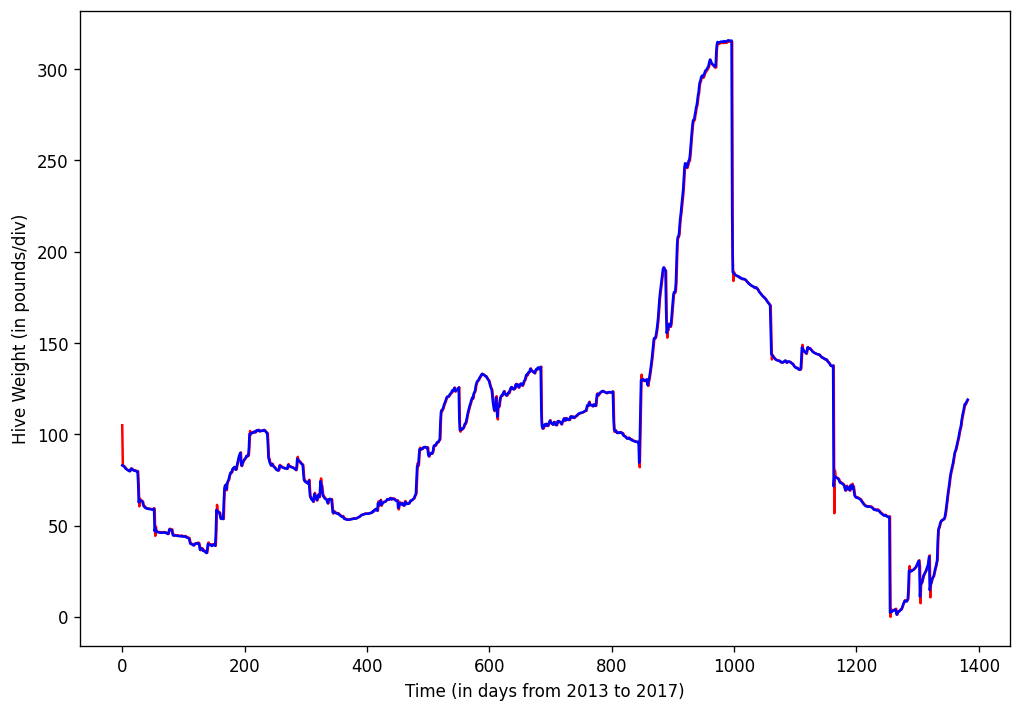

In [86]:
# We can start by running our initial ARIMA model without using exogenous variables
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

model = ARIMA(df.hive_weight, order=(p_initial,d_initial,q_initial))
arima = model.fit()

forecasts = arima.fittedvalues.to_numpy()
forecasts[forecasts < 0] = 0
print("Predicted: ", forecasts)
print("Actual: ", values)

plt.plot(forecasts, color = 'red')
plt.plot(values, color = 'blue')
plt.xlabel("Time (in days from 2013 to 2017)")
plt.ylabel("Hive Weight (in pounds/div)")

plt.show()

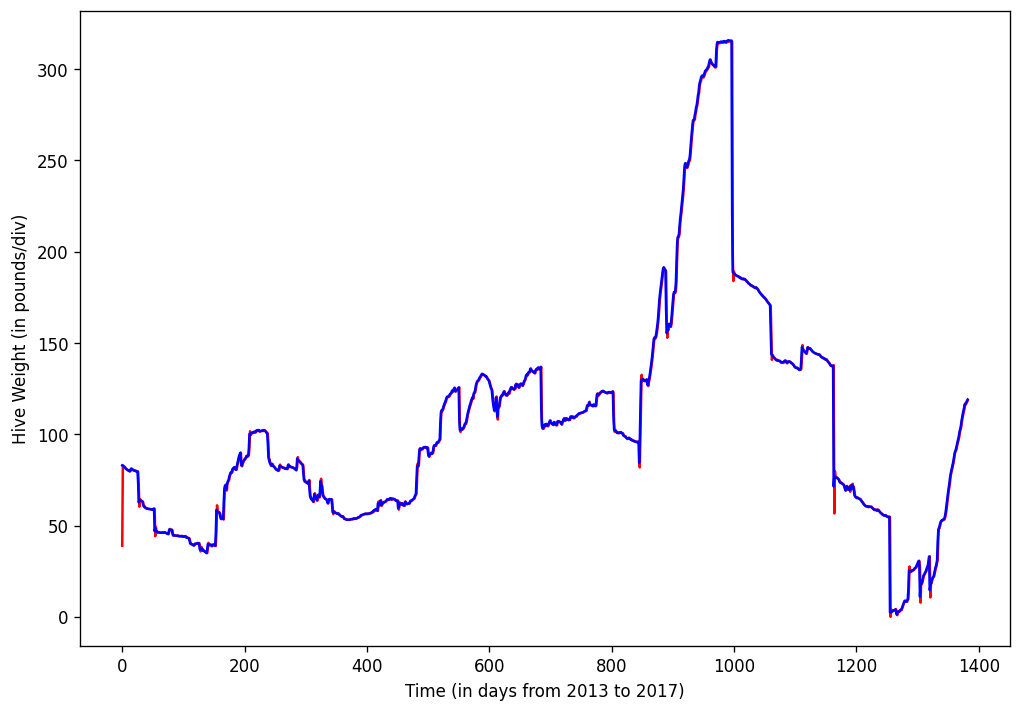

In [87]:
# Now we can test a (1, 0, 2) ARIMA model using exogenous variables

model = ARIMA(df.hive_weight, exog = exog, order=(1,0,2))
arimax = model.fit()

forecasts = arimax.fittedvalues

forecasts = forecasts.to_numpy()
forecasts[forecasts < 0] = 0

plt.plot(forecasts, color = 'red')
plt.plot(values, color = 'blue')
plt.xlabel("Time (in days from 2013 to 2017)")
plt.ylabel("Hive Weight (in pounds/div)")

plt.show()

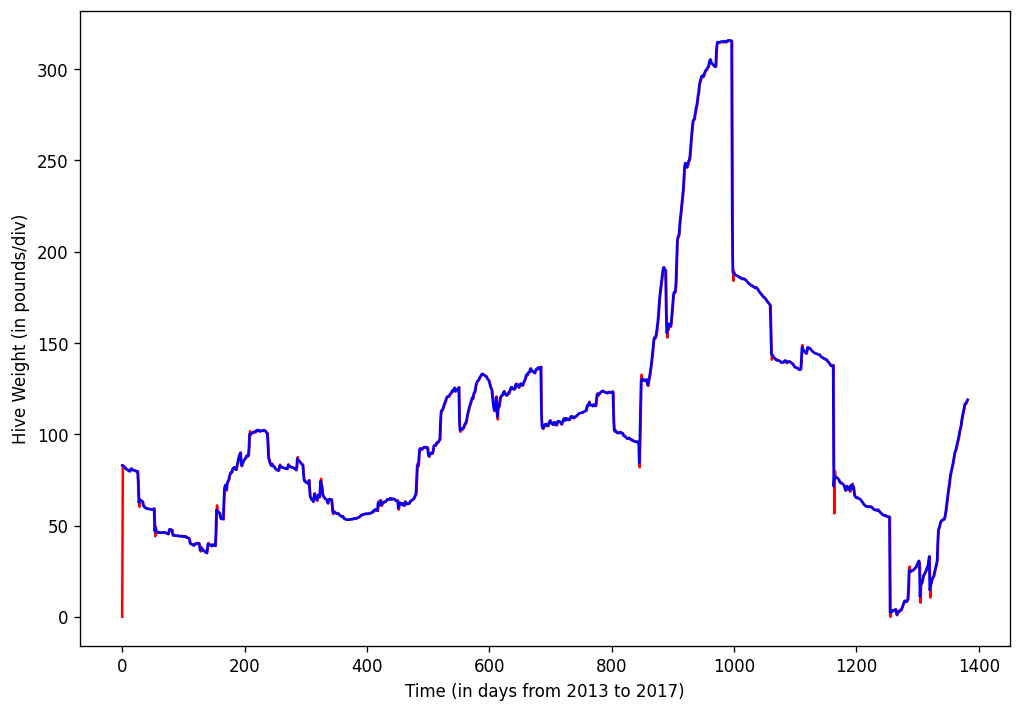

In [88]:
# Finally, we can test our forecasting on a SARIMAX model, which may be more effective since we know that our data is seasonal

from statsmodels.tsa.statespace.sarimax import SARIMAX

#0, 1, 2 SARIMAX Model
model= SARIMAX(df.hive_weight, exog = exog, order=(1,0,2), enforce_invertibility=False, enforce_stationarity=False)
sarimax = model.fit(disp=0)

forecasts = sarimax.fittedvalues.to_numpy()
forecasts[forecasts < 0] = 0

plt.plot(forecasts, color = 'red')
plt.plot(values, color = 'blue')
plt.xlabel("Time (in days from 2013 to 2017)")
plt.ylabel("Hive Weight (in pounds/div)")

plt.show()

In [92]:
# To look at next 50 forecast predictions

length = len(df.hive_weight)
amt = 5
diff = length - amt
# Create Training and Test
train = df.hive_weight[:diff]
exo_train = exog[:diff]
test = df.hive_weight[diff:]
exo_test = exog[diff:]
print(train.to_numpy())

[ 82.984  82.812  82.527 ... 112.684 114.388 116.344]


In [93]:
# Build Model
model = SARIMAX(train, order=(1, 0, 2))  
sarimax_test = model.fit()  

model2 = ARIMA(train, order = (1, 0, 2))
arima = model2.fit()

# Forecast
forecasts = arima.forecast(amt, alpha = 0.05)  # 95% conf

# Forecast
print(forecasts)

# Actual
print(test.to_numpy())

1392    116.707601
1393    116.709111
1394    116.669458
1395    116.629938
1396    116.590551
Name: predicted_mean, dtype: float64
[116.383 116.997 117.688 118.441 119.017]


In [91]:
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
import pickle

sarimax.save('hive_model.pkl')
loaded = SARIMAXResults.load('hive_model.pkl')

arima.save('hive_model_arima.pkl')
loaded_arima = ARIMAResults.load('hive_model_arima.pkl')
#pickle.dump('hive_model.pkl', open('hive_model.pkl', 'wb'))
print(loaded_arima.summary())

                               SARIMAX Results                                
Dep. Variable:            hive_weight   No. Observations:                 1333
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3793.218
Date:                Tue, 13 Apr 2021   AIC                           7596.436
Time:                        00:04:51   BIC                           7622.412
Sample:                             0   HQIC                          7606.170
                               - 1333                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.6052     71.719      1.472      0.141     -34.962     246.173
ar.L1          0.9966      0.002    540.692      0.000       0.993       1.000
ma.L1          0.2183      0.010     21.948      0.0